In [155]:
import torch 
import gpytorch
import config_safeopt as cfg
from GPTrainer import GPTrainer
import math
import gp_config as gp_cfg    
train_x = cfg.INITIAL_X
train_y = cfg.INITIAL_Y
%load_ext autoreload 
%autoreload 2
gp_trainer = GPTrainer(gp_cfg, train_x, train_y)

C_lower = torch.full_like(cfg.DOMAIN.flatten(), -float('inf'))
C_upper = torch.full_like(cfg.DOMAIN.flatten(), float('inf'))
C_lower[cfg.INITIAL_SAFE_INDICES] = cfg.SAFETY_THRESHOLD
    
S_mask = torch.zeros(cfg.N_POINTS, dtype=torch.bool)
S_mask[cfg.INITIAL_SAFE_INDICES] = True
    
# Pre-compute pairwise distances for the discrete domain D
distance_matrix = torch.cdist(cfg.DOMAIN, cfg.DOMAIN) 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [156]:
i = 0

In [ ]:
print("l_scale --" ,gp_trainer.model.covar_module.base_kernel.lengthscale.item())
print("output scale  -- " ,gp_trainer.model.covar_module.outputscale)
gp_trainer = GPTrainer(gp_cfg, train_x, train_y)
gp_trainer.train()
# gp_trainer.train_s(train_x, train_y)
print("l_scale --" ,gp_trainer.model.covar_module.base_kernel.lengthscale.item())
print("output scale  -- " ,gp_trainer.model.covar_module.outputscale)

mean, std_dev = gp_trainer.get_posterier(cfg.DOMAIN)

Q_lower = mean - math.sqrt(cfg.BETA) * std_dev
Q_upper = mean + math.sqrt(cfg.BETA) * std_dev

C_lower = torch.max(C_lower, Q_lower) 
C_upper = torch.min(C_upper,Q_upper)
# C_lower = Q_lower
# C_upper = Q_upper

S_prev_indices = torch.where(S_mask)[0]
new_S_mask = S_mask.clone()
for s_idx in S_prev_indices:
    # set of indicies for all points that are lipschitz safe relative to x[s_idx]
    lipschitz_safe = C_lower[s_idx] - cfg.LIPSCHITZ_CONSTANT * distance_matrix[s_idx] >= cfg.SAFETY_THRESHOLD
    new_S_mask = torch.logical_or(new_S_mask, lipschitz_safe)
S_mask = new_S_mask

if not torch.any(S_mask):
    print(f"Iteration {i+1}: Safe set is empty. Stopping.")
    

wt_D = C_upper - C_lower
wt_S = torch.full_like(wt_D, -1e9)
wt_S[S_mask] = wt_D[S_mask]

xt = cfg.DOMAIN[torch.argmax(wt_S)]
yt = cfg.ground_truth(xt) + torch.randn(1) * 0.2 # 

print (train_y.shape, yt.unsqueeze(0).shape , yt.shape)
train_x = torch.cat([train_x, xt.unsqueeze(0)])
train_y = torch.cat([train_y, yt])


print(f"Final train set size : {len(train_x)} \n Final safe set = {torch.where(S_mask)[0].tolist()}")

l_scale -- 0.1655033379793167
output scale  --  tensor(1.3379, grad_fn=<SoftplusBackward0>)
Iter 1/25 - Loss: 1.199   noise: 0.026   Length_scale: 0.693   output_scale: 0.693
Iter 2/25 - Loss: 0.739   noise: 0.032   Length_scale: 0.598   output_scale: 0.798
Iter 3/25 - Loss: 0.405   noise: 0.039   Length_scale: 0.513   output_scale: 0.913
Iter 4/25 - Loss: 0.212   noise: 0.045   Length_scale: 0.438   output_scale: 1.035
Iter 5/25 - Loss: 0.128   noise: 0.051   Length_scale: 0.375   output_scale: 1.156
Iter 6/25 - Loss: 0.105   noise: 0.057   Length_scale: 0.325   output_scale: 1.270
Iter 7/25 - Loss: 0.109   noise: 0.061   Length_scale: 0.284   output_scale: 1.372
Iter 8/25 - Loss: 0.122   noise: 0.064   Length_scale: 0.253   output_scale: 1.460
Iter 9/25 - Loss: 0.138   noise: 0.066   Length_scale: 0.228   output_scale: 1.534
Iter 10/25 - Loss: 0.151   noise: 0.067   Length_scale: 0.209   output_scale: 1.594
Iter 11/25 - Loss: 0.161   noise: 0.067   Length_scale: 0.193   output_scale:

In [186]:
train_x

tensor([[0.0816],
        [0.5102],
        [0.4082],
        [1.0000],
        [1.0000],
        [0.0816],
        [0.5102],
        [0.3469],
        [0.2857],
        [0.0000],
        [0.1837],
        [0.0000],
        [0.2245],
        [1.0000],
        [0.4082],
        [0.5102],
        [0.1429],
        [0.0000],
        [1.0000],
        [0.5102],
        [0.0000],
        [0.2857],
        [0.4082],
        [0.1020]])

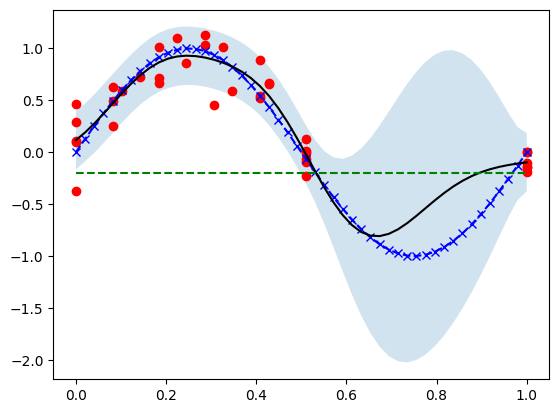

In [201]:
import matplotlib.pyplot as plt

plt.plot(train_x.numpy(), train_y.numpy(), 'ro', label='Training Data')
plt.plot(cfg.DOMAIN.numpy(), cfg.ground_truth(cfg.DOMAIN).numpy(), 'bx--', label='Ground Truth')
plt.plot(cfg.DOMAIN.numpy(), mean.numpy(), 'k-', label='GP Mean')
plt.plot(cfg.DOMAIN.numpy(), cfg.SAFETY_THRESHOLD * torch.ones_like(cfg.DOMAIN).numpy(), 'g--', label='Safety Threshold')
plt.fill_between(cfg.DOMAIN.numpy().flatten(), C_lower.numpy(), C_upper.numpy(), alpha=0.2, label='C Bounds')